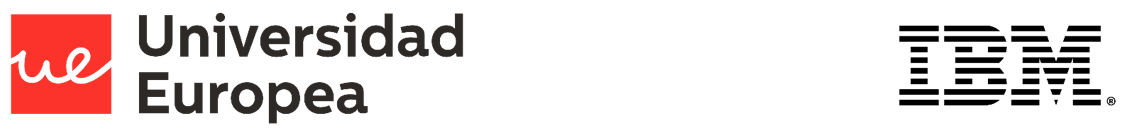
# <font color=#444444> Proyecto Parte I - Ciclo de Vida de los Modelos </font>
### <font color=#999999> Postgrado Onlie IA y Data Science 2020-2021 </font>  
**Guillermo Bances Bulnes**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
import torch
from skimage.feature import hog
import os
import pickle
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.pipeline import Pipeline
import collections
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

In [3]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0)

# 1. Carga, visualización/exploración y reescalado de las imágenes 

Las imágenes están almacenadas en formato pickle. Antes de desarrollar el modelo, al igual que hemos hecho en ejercicios anteriores, hay que cargar los datos y conviene hacer una exploración y visualización de las imágenes.

Este apartado consiste en:
 - Cargar las imágenes desde el pickle y comprobar el número de filas y resolución del dataset
 - Visualizar una serie de imágenes
 - Reescalar las imágenes para que los valores de los datos estén entre -0.5 y 0.5

In [4]:
with open('Semana 2 Dataset MNIST/imagenes/MNIST_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)
with open('Semana 2 Dataset MNIST/imagenes/MNIST_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


<Figure size 864x864 with 0 Axes>

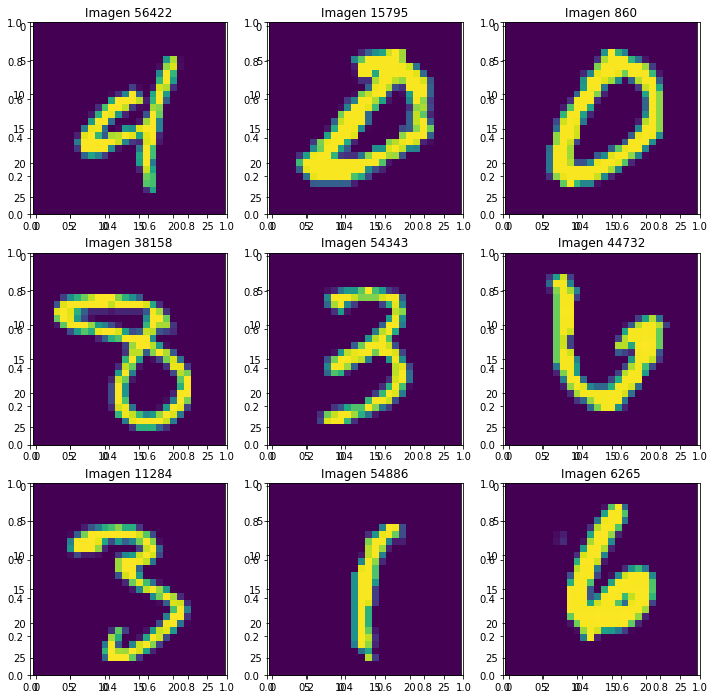

In [6]:
#Mostramos 9 imágenes
plt.figure()
np.random.seed(42)
a = np.random.randint(60000, size=9)
fig,ax=plt.subplots(3,3)
for i in range(len(a)):
    fig.add_subplot(3,3, i+1) 
    subplot_title=("Imagen "+str(a[i]))
    plt.imshow(X_train[a[i]])
    plt.title(subplot_title)
plt.show()

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

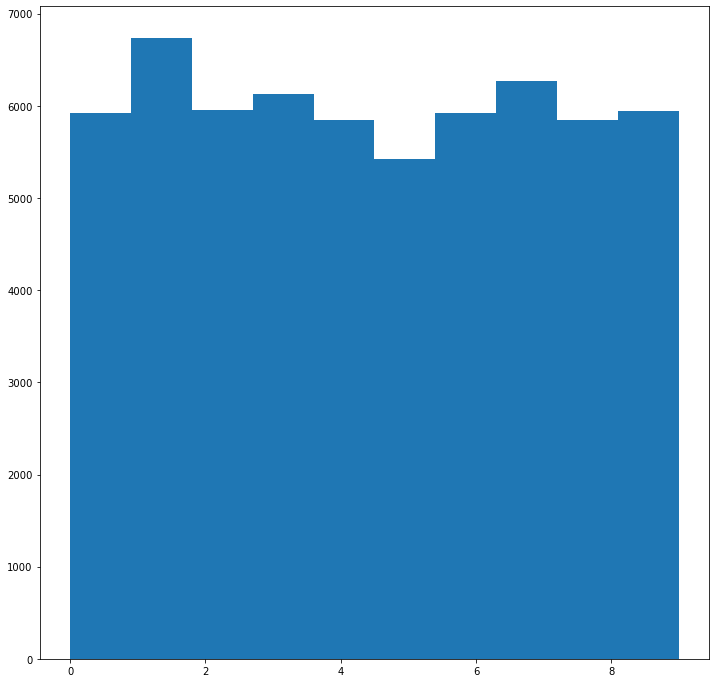

In [7]:
plt.hist(y_train) #Para comprobar que hay muestra similar de todos los tipos de digitos, tanto en los datos de 
#entrenamiento como de test

In [ ]:
plt.hist(y_test)#Para comprobar que hay muestra similar de todos los tipos de digitos, tanto en los datos de 
#entrenamiento como de test

In [9]:
X_train_normalizado = (X_train.reshape(X_train.shape[0],-1) / 255.0) - 0.5
X_test_normalizado = (X_test.reshape(X_test.shape[0],-1) / 255.0) - 0.5
print("Valor máximo: " + str(X_train_normalizado.max()))
print("Valor mínimo: " + str(X_train_normalizado.min()))
print("Shape X_train: " + str(X_train_normalizado.shape))
print("Shape X_test: " + str(X_test_normalizado.shape))

Valor máximo: 0.5
Valor mínimo: -0.5
Shape X_train: (60000, 784)
Shape X_test: (10000, 784)


# 2. Entrenamiento de modelos de ML tradicionales con HOG features (2 puntos)

Para conseguir modelos mas robustos, podemos hacer uso de HOG features para procesar las imágenes de forma que obtengamos unas variables de entrada mas genéricas que los valores específicos de los píxeles.

Esta parte consiste en, al igual que hicimos en ejercicios anteriores:
 - Extraer las HOG features de las imágenes para obtener un dataset transformado con el que entrenar
 - Elegir 3 algoritmos de ML clásico (de scikit-learn) y entrenar modelos de clasificación con el dataset transformado 

In [10]:
#Voy a utilizar 3 modelos: SVC, K-vecinos y un Random Forest

svc = SVC(random_state = 40, probability = True)
svc.fit(X=X_train_normalizado[::10], y=y_train[::10])
print("Resultado SVC con datos entrenamiento: " + str(svc.score(X=X_train_normalizado, y=y_train)))
print("Resultado SVC con datos test: " + str(svc.score(X=X_test_normalizado, y=y_test)))

#Resultado SVC con datos entrenamiento: 0.9486
#Resultado SVC con datos test: 0.9501

Resultado SVC con datos entrenamiento: 0.9486
Resultado SVC con datos test: 0.9501


In [55]:
KNC = KNeighborsClassifier()
KNC.fit(X=X_train_normalizado[::10], y=y_train[::10])
print("Resultado KNeighbors con datos entrenamiento: " + str(KNC.score(X=X_train_normalizado, y=y_train)))
print("Resultado KNeighbors con datos test: " + str(KNC.score(X=X_test_normalizado, y=y_test)))

#Resultado KNeighbors con datos entrenamiento: 0.9338333333333333
#Resultado KNeighbors con datos test: 0.937

KeyboardInterrupt: 

In [56]:

forest_clf = RandomForestClassifier(random_state = 40)
forest_clf.fit(X=X_train_normalizado[::10], y=y_train[::10])
print("Resultado Random Forest con datos entrenamiento: " + str(forest_clf.score(X=X_train_normalizado, y=y_train)))
print("Resultado Random Forest con datos test: " + str(forest_clf.score(X=X_test_normalizado, y=y_test)))

#Resultado Random Forest con datos entrenamiento: 0.9398333333333333
#Resultado Random Forest con datos test: 0.9388

KeyboardInterrupt: 

In [57]:
#Calculo de las HOG features

X_train_hog = np.concatenate([np.concatenate([hog(xi/255.0, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_train[::10,:,:]],
                                              axis=0) for ppc in [14,7]], axis=1)
X_test_hog = np.concatenate([np.concatenate([hog(xi/255.0, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test[:,:,:]],
                                              axis=0) for ppc in [14,7]], axis=1)

In [58]:
svc.fit(X=X_train_hog, y=y_train[::10])
print("Resultado SVC con datos entrenamiento: " + str(svc.score(X=X_train_hog, y=y_train[::10])))
print("Resultado SVC con datos test: " + str(svc.score(X=X_test_hog, y=y_test)))

KNC.fit(X=X_train_hog, y=y_train[::10])
print("Resultado KNeighbors con datos entrenamiento: " + str(KNC.score(X=X_train_hog, y=y_train[::10])))
print("Resultado KNeighbors con datos test: " + str(KNC.score(X=X_test_hog, y=y_test)))

forest_clf.fit(X=X_train_hog, y=y_train[::10])
print("Resultado Random Forest con datos entrenamiento: " + str(forest_clf.score(X=X_train_hog, y=y_train[::10])))
print("Resultado Random Forest con datos test: " + str(forest_clf.score(X=X_test_hog, y=y_test)))

#Resultado SVC con datos entrenamiento: 0.9838333333333333
#Resultado SVC con datos test: 0.9529
#Resultado KNeighbors con datos entrenamiento: 0.9168333333333333
#Resultado KNeighbors con datos test: 0.8742
#Resultado Random Forest con datos entrenamiento: 1.0
#Resultado Random Forest con datos test: 0.9446

Resultado SVC con datos entrenamiento: 0.9838333333333333
Resultado SVC con datos test: 0.9529
Resultado KNeighbors con datos entrenamiento: 0.9168333333333333
Resultado KNeighbors con datos test: 0.8742
Resultado Random Forest con datos entrenamiento: 1.0
Resultado Random Forest con datos test: 0.9446


# 3.	Grid search de hiperparámetros de los modelos y HOG features (1 punto)

Para refinar los modelos entrenados en el apartado anterior, en este apartado el objetivo es:
- Desarrollar una pipeline de scikit-learn con las transformaciones realizadas (incluyendo HOG features) y los modelos desarrollados
- Hacer un grid search sobre esta pipeline para hacer una selección de los hiperparámetros los modelos y de los hiperparámetros de la transformación HOG

In [ ]:
svc_param1={  'C': [0.1, 1,5, 10,15,20,100,500],  
              'gamma': [0.5,0.80,1, 0.1], 
              'kernel': ['rbf','linear','sigmoid']}
svc_param2={  'C': [0.1, 1,5, 10,15,20,100,500],  
              'gamma': [0.5,0.80,1, 0.1], 
              'degree': list(range(1,6)),
              'kernel': ['poly']}

svc_search1 = GridSearchCV(SVC(), svc_param1, cv = 5, scoring = 'accuracy', n_jobs = -1)
svc_search2 = GridSearchCV(SVC(), svc_param2, cv = 5, scoring = 'accuracy', n_jobs = -1)

svc_search1.fit(X=X_train_hog, y=y_train[::10])
svc_search2.fit(X=X_train_hog, y=y_train[::10])

print("Resultado SVC con GridSearch y datos entrenamiento: " + str(svc_search1.score(X=X_train_hog, y=y_train[::10])))
print("Resultado SVC con GridSearch y datos test: " + str(svc_search1.score(X=X_test_hog, y=y_test)))
print("Resultado SVC polinomial con GridSearch y datos entrenamiento: " + str(svc_search2.score(X=X_train_hog, y=y_train[::10])))
print("Resultado SVC polinomial con GridSearch y datos test: " + str(svc_search2.score(X=X_test_hog, y=y_test)))

kn_param = {'n_neighbors': list(range(1,20)),
            'leaf_size': [20,40,100,250,400],
            'algorithm':['auto', 'kd_tree', 'ball_tree','brute'],
            'weights': ["uniform", "distance"],
            'metric': ('minkowski', 'chebyshev', 'euclidean', 'manhattan')}

kn_search = GridSearchCV(KNeighborsClassifier(), kn_param, cv = 5, scoring = 'accuracy', n_jobs = -1)
kn_search.fit(X=X_train_hog, y=y_train[::10])
print("Resultado KNeighbors con datos entrenamiento: " + str(kn_search.score(X=X_train_hog, y=y_train[::10])))
print("Resultado KNeighbors con datos test: " + str(kn_search.score(X=X_test_hog, y=y_test)))

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf_param = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

forest_clf_search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = rf_param, n_iter = 100, cv = 5, random_state=42, scoring = 'accuracy', n_jobs = -1)
forest_clf_search.fit(X=X_train_hog, y=y_train[::10])
print("Resultado Random Forest con datos entrenamiento: " + str(forest_clf_search.score(X=X_train_hog, y=y_train[::10])))
print("Resultado Random Forest con datos test: " + str(forest_clf_search.score(X=X_test_hog, y=y_test)))

#Resultado SVC con GridSearch y datos entrenamiento: 0.9908333333333333
#Resultado SVC con GridSearch y datos test: 0.9537
#Resultado SVC polinomial con GridSearch y datos entrenamiento: 0.9886666666666667
#Resultado SVC polinomial con GridSearch y datos test: 0.9535
#Resultado KNeighbors con datos entrenamiento: 1.0
#Resultado KNeighbors con datos test: 0.9266
#Resultado Random Forest con datos entrenamiento: 1.0
#Resultado Random Forest con datos test: 0.9558

# 4. Diseño de red neuronal “fully connected”, no convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, los modelos de Deep Learning son capaces de "capturar" features a partir de los datos. 

El objetivo de esta sección es:
- Construir una red neuronal no convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [6]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [7]:
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

In [8]:
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

In [9]:
def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y)

In [10]:
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

In [14]:
def t_step(x, y, forw, opt):
    opt.zero_grad() # reseteamos los valores acumulados de las derivadas
    loss = loss_f(x, y, forw) # calculamos la 'loss' con los resultados 
    out = loss.item() # almacenamos nuestro valor de loss para devolverlo como resultado intermedio
    loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
    opt.step() # ejecutamos un paso de nuestro optimizador
    return out

In [27]:
tX_train = torch.tensor(X_train_normalizado, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test_normalizado, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long) 

tX_train_l = tX_train.view(tX_train.shape[0], 784)
tX_test_l = tX_test.view(tX_test.shape[0], 784)

nn1 = torch.nn.Sequential(
    torch.nn.Linear(784,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10), 
    Flatten(),
    torch.nn.LogSoftmax(dim=1) 
)
do_seeds(29)
init_f(nn1)
print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

0.1068
0.1088


In [4]:
tX_train = torch.tensor(X_train_normalizado, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test_normalizado, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long) 

tX_train_l = tX_train.view(tX_train.shape[0], 784)
tX_test_l = tX_test.view(tX_test.shape[0], 784)

In [5]:
tX_train.shape

torch.Size([60000, 784])

In [6]:
tX_train_l.shape

torch.Size([60000, 784])

# 5. Entrenamiento red neuronal “fully connected”. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [28]:
opt1 = torch.optim.SGD(nn1.parameters(), lr=0.0025)
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train_l, ty_train), 
                                       batch_size=100, shuffle=True) # shuffle: reordena el dataset en cada epoch
for i in range(100): 
    for x_j, y_j in mini_b:
        out = t_step(x_j.unsqueeze(1), y_j, nn1, opt1) 
    if i%1 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))
        
#Epoch: 0, Loss: 1.6034
#Epoch: 99, Loss: 0.0264

Epoch: 0, Loss: 1.2164
Epoch: 1, Loss: 0.7442
Epoch: 2, Loss: 0.5254
Epoch: 3, Loss: 0.5261
Epoch: 4, Loss: 0.4836
Epoch: 5, Loss: 0.4793
Epoch: 6, Loss: 0.4303
Epoch: 7, Loss: 0.3636
Epoch: 8, Loss: 0.4163
Epoch: 9, Loss: 0.4866
Epoch: 10, Loss: 0.4331
Epoch: 11, Loss: 0.2736
Epoch: 12, Loss: 0.4115
Epoch: 13, Loss: 0.4453
Epoch: 14, Loss: 0.2674
Epoch: 15, Loss: 0.2806
Epoch: 16, Loss: 0.2859
Epoch: 17, Loss: 0.2384
Epoch: 18, Loss: 0.2373
Epoch: 19, Loss: 0.3858
Epoch: 20, Loss: 0.2057
Epoch: 21, Loss: 0.3292
Epoch: 22, Loss: 0.3992
Epoch: 23, Loss: 0.3815
Epoch: 24, Loss: 0.2353
Epoch: 25, Loss: 0.3999
Epoch: 26, Loss: 0.3290
Epoch: 27, Loss: 0.2564
Epoch: 28, Loss: 0.2976
Epoch: 29, Loss: 0.1702
Epoch: 30, Loss: 0.3721
Epoch: 31, Loss: 0.3943
Epoch: 32, Loss: 0.4120
Epoch: 33, Loss: 0.2147
Epoch: 34, Loss: 0.4388
Epoch: 35, Loss: 0.3260
Epoch: 36, Loss: 0.3351
Epoch: 37, Loss: 0.3058
Epoch: 38, Loss: 0.2889
Epoch: 39, Loss: 0.2319
Epoch: 40, Loss: 0.1864
Epoch: 41, Loss: 0.3121
Ep

In [16]:
print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

0.9831333333333333
0.9439


In [29]:
print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

0.9429
0.9416


# 6. Diseño de red neuronal convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, las redes convolucionales presentan mejores resultados para la clasificación de imágenes, ya que capturan mejor la estructura y correlación entre píxeles cercanos. 

El objetivo de esta sección es:
- Construir una red neuronal convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [31]:
X_train_normalizado = (X_train / 255.0)
X_test_normalizado = (X_test / 255.0)

tX_train = torch.tensor(X_train_normalizado, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test_normalizado, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long) 

nn2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Dropout(p=0.5, inplace=False),
    Flatten(),
    torch.nn.Linear(1960, 10), 
    torch.nn.LogSoftmax(dim=1) 
)
do_seeds(29)
init_f(nn2)
print(score_f(tX_train.unsqueeze(1), ty_train, nn2))
print(score_f(tX_test.unsqueeze(1), ty_test, nn2))

0.0942
0.091


# 7. Entrenamiento red neuronal convolucional. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [32]:
opt3 = torch.optim.Adam(nn2.parameters(), weight_decay=0.008, lr=0.0002)
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train, ty_train), 
                                       batch_size=100, shuffle=True) # shuffle: reordena el dataset en cada epoch
for i in range(50): 
    for x_j, y_j in mini_b:
        out = t_step(x_j.unsqueeze(1), y_j, nn2, opt3) 
    if i%1 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))
        
#Epoch: 0, Loss: 1.6333
#Epoch: 49, Loss: 0.1247

Epoch: 0, Loss: 0.4437
Epoch: 1, Loss: 0.2892
Epoch: 2, Loss: 0.2680
Epoch: 3, Loss: 0.4451
Epoch: 4, Loss: 0.1934
Epoch: 5, Loss: 0.2373
Epoch: 6, Loss: 0.2406
Epoch: 7, Loss: 0.3294
Epoch: 8, Loss: 0.2517
Epoch: 9, Loss: 0.1745
Epoch: 10, Loss: 0.1610
Epoch: 11, Loss: 0.1622
Epoch: 12, Loss: 0.2322
Epoch: 13, Loss: 0.1625
Epoch: 14, Loss: 0.1616
Epoch: 15, Loss: 0.0926
Epoch: 16, Loss: 0.1039
Epoch: 17, Loss: 0.1612
Epoch: 18, Loss: 0.1190
Epoch: 19, Loss: 0.1523
Epoch: 20, Loss: 0.1817
Epoch: 21, Loss: 0.1665
Epoch: 22, Loss: 0.1934
Epoch: 23, Loss: 0.1194
Epoch: 24, Loss: 0.2044
Epoch: 25, Loss: 0.1264
Epoch: 26, Loss: 0.1877
Epoch: 27, Loss: 0.1775
Epoch: 28, Loss: 0.1322
Epoch: 29, Loss: 0.1960
Epoch: 30, Loss: 0.1972
Epoch: 31, Loss: 0.1730
Epoch: 32, Loss: 0.1378
Epoch: 33, Loss: 0.1920
Epoch: 34, Loss: 0.1995
Epoch: 35, Loss: 0.1240
Epoch: 36, Loss: 0.1914
Epoch: 37, Loss: 0.1105
Epoch: 38, Loss: 0.1532
Epoch: 39, Loss: 0.1504
Epoch: 40, Loss: 0.1418
Epoch: 41, Loss: 0.2762
Ep

In [20]:
print(score_f(tX_train.unsqueeze(1), ty_train, nn2))
print(score_f(tX_test.unsqueeze(1), ty_test, nn2))

#Resultado datos entrenamiento: 0.9806833333333334
#Resultado datos test: 0.9757

0.9773333333333334
0.9735


In [33]:
print(score_f(tX_train.unsqueeze(1), ty_train, nn2))
print(score_f(tX_test.unsqueeze(1), ty_test, nn2))

0.9565166666666667
0.96


# 8. Comparativa de métricas y matrices de confusión entre todos los modelos entrenados de ML y DL. (1 punto)

El objetivo de esta sección es comparar los resultados obtenidos entre los distintos modelos (ML, NN, CNN). 

En particular:
- Mostrar la matriz de confusión para cada modelo.
- Elegir y dibujar algunas métricas adicionales. 
- Describir las conclusiones.

In [59]:
kfold = StratifiedKFold(n_splits=10)

In [62]:
#MATRIZ CONFUSION SVC
kfold = StratifiedKFold(n_splits=10)
y_pred_svc = cross_val_predict(svc, X_test_hog, y_test, cv=kfold)
print(confusion_matrix(y_test, y_pred_svc))

[[ 968    2    0    0    1    0    5    1    2    1]
 [   0 1114    5    2    4    1    5    3    1    0]
 [   3    2 1014    5    2    0    1    3    2    0]
 [   2    0   12  961    1   11    0    7   13    3]
 [   0    4    1    0  947    0    3    0    1   26]
 [   2    0    0   19    0  855    2    1   11    2]
 [   3    5    2    0    3    5  934    0    5    1]
 [   0    3   13    3    8    0    0  972    3   26]
 [   8    2    7    7    7    5    2    5  923    8]
 [   2    5    3   16   11    6    0   22    4  940]]


In [63]:
#MATRIZ CONFUSION KNEIGHBORS
y_pred_kn = cross_val_predict(KNC, X_test_hog, y_test, cv=kfold)
print(confusion_matrix(y_test, y_pred_kn))

[[ 957    4    0    1    1    3    8    0    5    1]
 [   0 1107    2    3    6    0    7    3    5    2]
 [  30    2  854   87    3    2    5    9   37    3]
 [  12    1   20  920    0   23    0    4   24    6]
 [   3   11    2    1  833    0    9    7    8  108]
 [  15    0    2   93    1  717   12    2   41    9]
 [  25    7    1    1    4    8  900    1   10    1]
 [   0    4   11   17   21    0    0  843    8  124]
 [  35    7   12   42    8   23   13   11  805   18]
 [  12    4    1   14    9    7    0   27   12  923]]


In [64]:
#MATRIZ CONFUSION RANDOM FOREST
y_pred_random = cross_val_predict(forest_clf, X_test_hog, y_test, cv=kfold)
print(confusion_matrix(y_test, y_pred_random))

[[ 968    3    1    1    1    2    2    1    1    0]
 [   0 1113    6    3    6    0    3    3    1    0]
 [   5    1  991   14    5    0    2    3   11    0]
 [   2    0   11  963    2   10    0    7   13    2]
 [   1    3    4    0  939    0    7    6    1   21]
 [   0    1    1   19    0  844    6    2   17    2]
 [   8    6    4    0    2    2  931    0    5    0]
 [   0    2   18    1   12    1    0  961    1   32]
 [  10    2   11   11    5   13    7    6  900    9]
 [   6    5    6   17   19    4    1   22    2  927]]


In [38]:
def matriz_confusion(X,y,red):
    predicciones = pred_f(X,red)
    matriz = np.zeros([10,10])
    matriz_normalizada = np.zeros([10,10])
    pesos = collections.Counter(np.uint8(y))
    for i in range(np.array(X).shape[0]):
        matriz[y[i], np.uint8(predicciones)[i]] = matriz[y[i], np.uint8(predicciones)[i]] + 1
        matriz_normalizada[y[i], np.uint8(predicciones)[i]] = matriz_normalizada[y[i], np.uint8(predicciones)[i]] + 1
    for j in range(0,10):
        matriz_normalizada[j,:] = matriz_normalizada[j,:] / pesos[j]
    fig, ax = plt.subplots()
    ax.matshow(matriz_normalizada, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_ylabel('Valor real')
    ax.set_xlabel('Predicción')

    for i in range(0,10):
        for j in range(0,10):
            c = matriz_normalizada[j,i]
            ax.text(i, j, str(round(c, 2)), va='center', ha='center')

    fig2, ax2 = plt.subplots()
    ax2.matshow(matriz, cmap=plt.cm.Blues)
    ax2.set_xticks(np.arange(10))
    ax2.set_yticks(np.arange(10))
    ax2.set_ylabel('Valor real')
    ax2.set_xlabel('Predicción')
    for i in range(0,10):
        for j in range(0,10):
            c = matriz[j,i]
            ax2.text(i, j, str(round(c, 2)), va='center', ha='center')
    return matriz, matriz_normalizada;

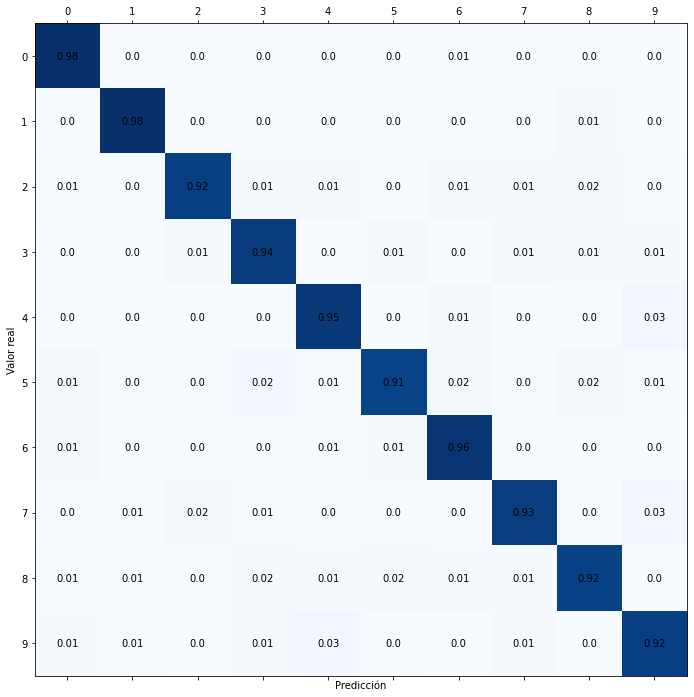

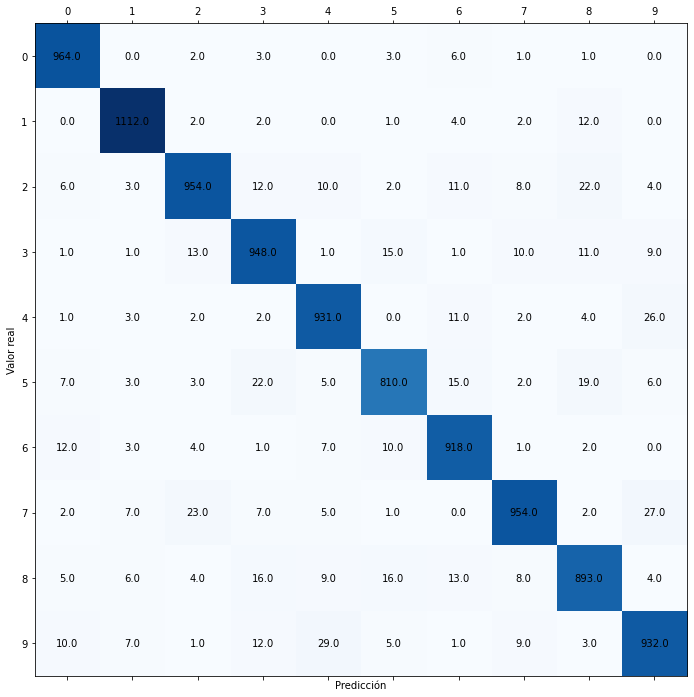

In [39]:
matriz_nn, matriz_nn_norm = matriz_confusion(tX_test_l, ty_test,nn1)

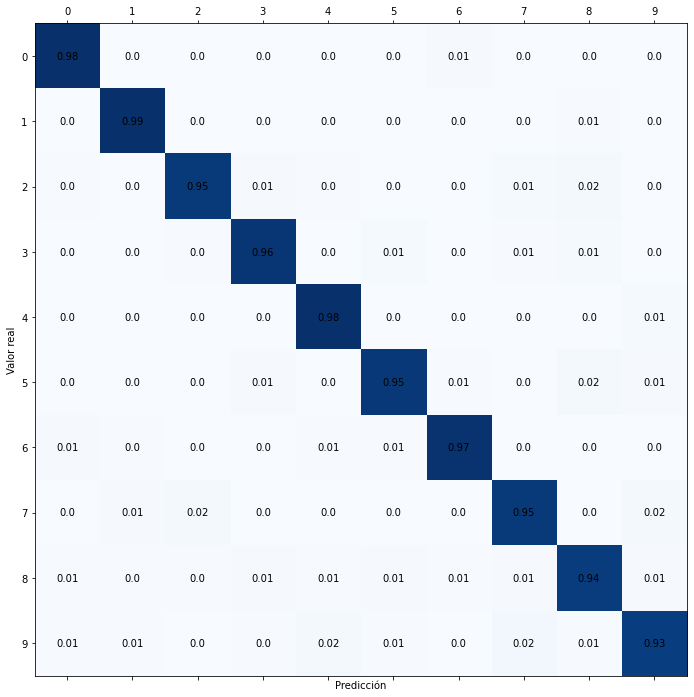

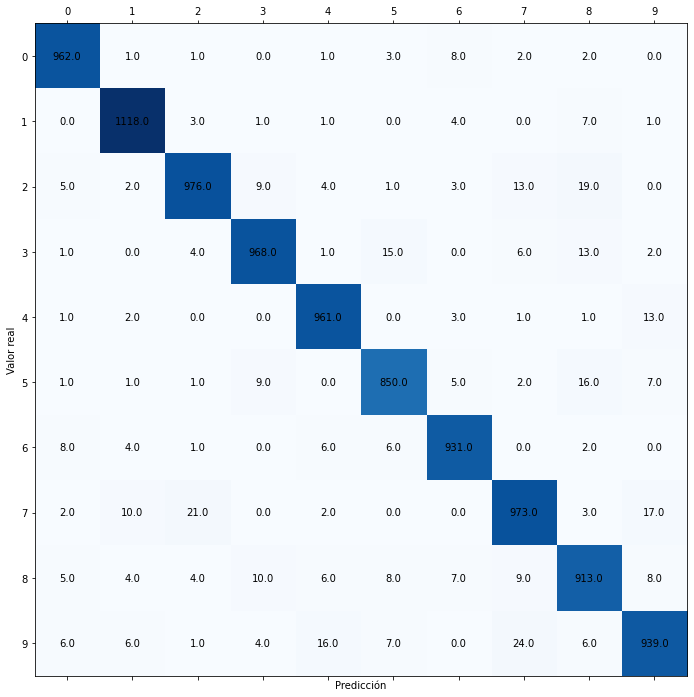

In [40]:
matriz_cnn, matriz_cnn_norm = matriz_confusion(tX_test.unsqueeze(1), ty_test,nn2)

# 9. Comparativa de la robustez de los distintos modelos entrenados frente a la translación horizontal de los dígitos. (0,5 puntos)

El objetivo de esta sección es:
- Probar el rendimiento de los modelos entrenados sobre distintas transformaciones del set de testing (por ejemplo, sobre translaciones horizontales como se mostró en las sesiones de este módulo).
- Dibujar las gráficas correspondientes de acierto frente a la magnitud de la transformación (por ej. cantidad de píxeles desplazados).
- Describir las conclusiones.

In [45]:
tr_W = np.array(list(range(-14,14)))
X_test_Ws = [np.roll(X_test, i, axis=1) for i in tr_W]

nn1_scores = [score_f(torch.tensor(xi.reshape(xi.shape[0],-1), requires_grad=False, dtype=torch.float).unsqueeze(1), 
                      ty_test, nn1) for xi in X_test_Ws]

cnn1_scores = [score_f(torch.tensor(xi, requires_grad=False, dtype=torch.float).unsqueeze(1), 
                      ty_test, nn2) for xi in X_test_Ws]

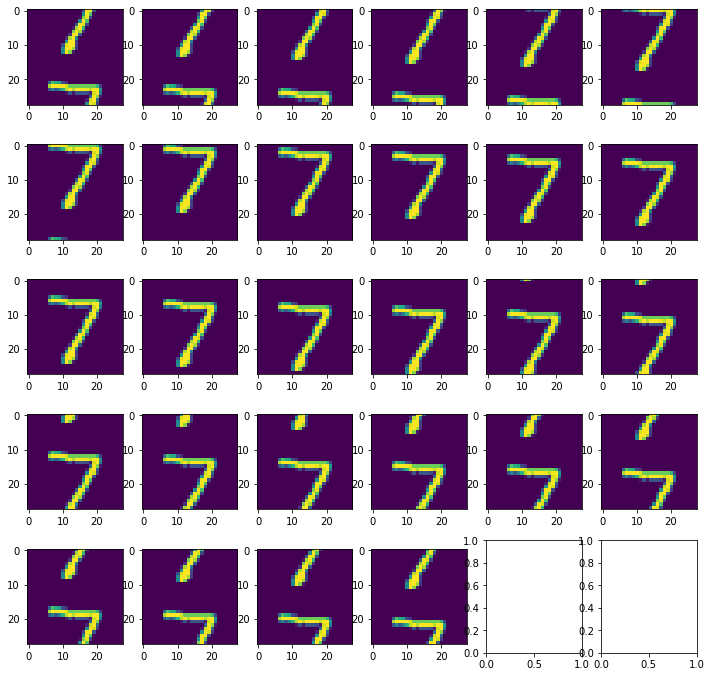

In [46]:
im = io.imshow_collection([0.5+xi[0,:,:] for xi in X_test_Ws])

In [48]:
tr_W = np.array(list(range(-14,14)))
X_test_Ws = [np.roll(X_test, i, axis=2) for i in tr_W]

nn2_scores = [score_f(torch.tensor(xi.reshape(xi.shape[0],-1), requires_grad=False, dtype=torch.float).unsqueeze(1), 
                      ty_test, nn1) for xi in X_test_Ws]

cnn2_scores = [score_f(torch.tensor(xi, requires_grad=False, dtype=torch.float).unsqueeze(1), 
                      ty_test, nn2) for xi in X_test_Ws]

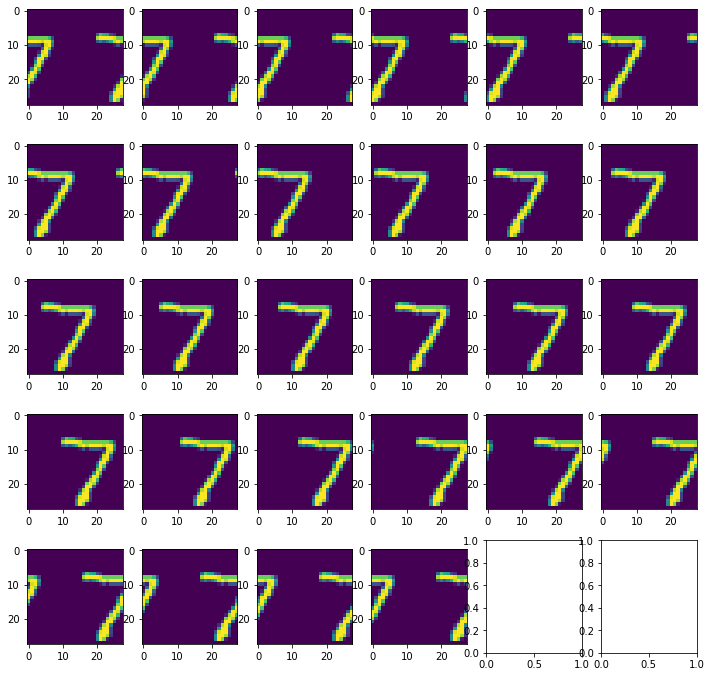

In [49]:
im = io.imshow_collection([0.5+xi[0,:,:] for xi in X_test_Ws])

In [116]:
tr_W = np.array(list(range(-14,14)))
X_test_Ws = np.array([np.roll(X_test, i, axis=1) for i in tr_W])

X_test_hog = np.zeros([28,10000,160])
svc_scores = np.zeros([28,1])
knc_scores = np.zeros([28,1])
forest_scores = np.zeros([28,1])
for i in range(X_test_Ws.shape[0]):
    X_test_hog[i] = np.concatenate([np.concatenate([hog(xi/255.0, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test_Ws[i,:,:,:]],
                                              axis=0) for ppc in [14,7]], axis=1)
    svc_scores[i] = svc.score(X=X_test_hog[i], y=y_test) 
    knc_scores[i] = KNC.score(X=X_test_hog[i], y=y_test) 
    forest_scores[i] = forest_clf.score(X=X_test_hog[i], y=y_test) 

In [118]:
tr_W = np.array(list(range(-14,14)))
X_test_Ws = np.array([np.roll(X_test, i, axis=2) for i in tr_W])

X_test_hog = np.zeros([28,10000,160])
svc_scores2 = np.zeros([28,1])
knc_scores2 = np.zeros([28,1])
forest_scores2 = np.zeros([28,1])
for i in range(X_test_Ws.shape[0]):
    X_test_hog[i] = np.concatenate([np.concatenate([hog(xi/255.0, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test_Ws[i,:,:,:]],
                                              axis=0) for ppc in [14,7]], axis=1)
    svc_scores2[i] = svc.score(X=X_test_hog[i], y=y_test) 
    knc_scores2[i] = KNC.score(X=X_test_hog[i], y=y_test) 
    forest_scores2[i] = forest_clf.score(X=X_test_hog[i], y=y_test) 

<function matplotlib.pyplot.show(close=None, block=None)>

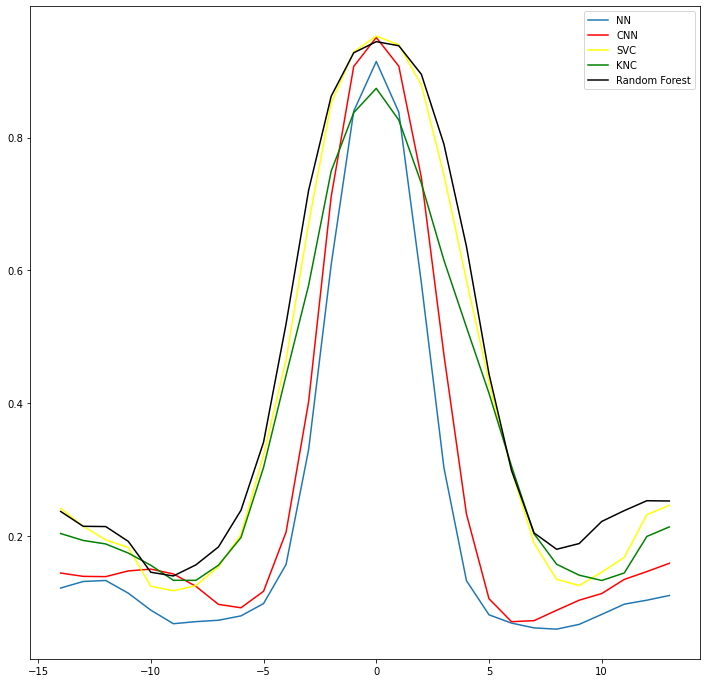

In [119]:
all_scores = pd.DataFrame(data={
    'nn': nn1_scores,
    'cnn': cnn1_scores,
    'svc': svc_scores.reshape(-1),
    'knc': knc_scores.reshape(-1),
    'forest': forest_scores.reshape(-1)
}, index=tr_W)
plt.plot(all_scores['nn'])
plt.plot(all_scores['cnn'],color='red')
plt.plot(all_scores['svc'],color='yellow')
plt.plot(all_scores['knc'],color='green')
plt.plot(all_scores['forest'],color='black')
plt.legend(['NN','CNN','SVC','KNC','Random Forest'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

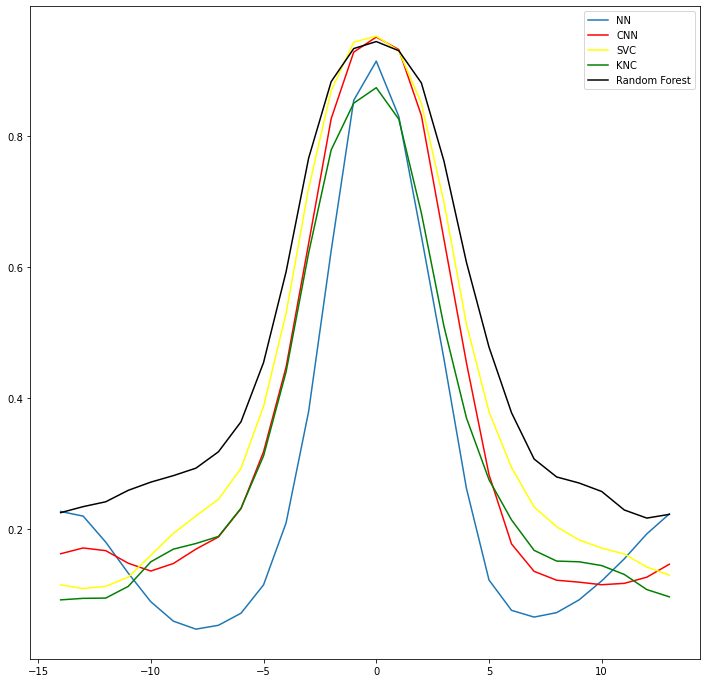

In [120]:
all_scores2 = pd.DataFrame(data={
    'nn': nn2_scores,
    'cnn': cnn2_scores,
    'svc': svc_scores2.reshape(-1),
    'knc': knc_scores2.reshape(-1),
    'forest': forest_scores2.reshape(-1)
}, index=tr_W)
plt.plot(all_scores2['nn'])
plt.plot(all_scores2['cnn'],color='red')
plt.plot(all_scores2['svc'],color='yellow')
plt.plot(all_scores2['knc'],color='green')
plt.plot(all_scores2['forest'],color='black')
plt.legend(['NN','CNN','SVC','KNC','Random Forest'])
plt.show

# 10. Desarrollo de una función de preprocesado / reescalado para input al modelo, y exportación del modelo escogido. (0,5 puntos)


El objetiivo de esta sección es el de preparar el modelo para su despliegue en la Parte II de la práctica.

Para ello, habrá que:
- Seleccionar el mejor modelo entre los probados (típicamente, debería ser la CNN).
- Construir una función de preprocesado (o una pipeline de scikit-learn, o equivale) que transforme una imágen genérica en algo consumible por el modelo, replicando también las transformaciones hechas durante el entrenamiento.
- Exportar el modelo y la pipeline en un formato importable desde una aplicación python, como por ejemplo un fichero “.pt” (pytorch) con los pesos de la red neuronal, o una de la pipeline entera a un fichero “.pkl” (pickle).


In [164]:
def preprocess(input_img):
    X_train_normalizado = (input_img / 255.0)
    tX_train = torch.tensor(X_train_normalizado, requires_grad=False, dtype=torch.float)
    return tX_train.unsqueeze(1)

In [165]:
def predict_img(input_img,forw):
    tX_train = preprocess(input_img)
    pred_n = pred_f(tX_train, forw)
    pred_p = np.exp(forw(tX_train).detach().numpy())[0][pred_n]
    return pred_n, pred_p

In [169]:
torch.save(nn2, 'red_convolucional.pt')

In [170]:
modelo = torch.load('red_convolucional.pt')
p, j = predict_img(X_train[0:8],modelo)

In [171]:
p

tensor([3, 0, 4, 1, 9, 2, 1, 3])